In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib.patches as patches
import numpy as np
import os
import math
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, FancyArrowPatch
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import pymc as pm
import pytensor.tensor as pt
import pytensor as pyt
import xarray as xr
import arviz as az
from matplotlib.patches import Ellipse
import requests

In [32]:
# DOI for your dataset
doi_url = "https://doi.org/10.6084/m9.figshare.27061012.v1"

# Convert DOI to the Figshare URL
figshare_api_url = "https://api.figshare.com/v2/articles/27061012"

# Fetch the metadata of the Figshare article
response = requests.get(figshare_api_url)
article_metadata = response.json()

# Extract files from the metadata
files = article_metadata['files']

# Download only the CSV files
for file in files:
    file_name = file['name']
    file_url = file['download_url']
    
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        print(f"Downloading {file_name}...")
        
        # Request the file
        file_response = requests.get(file_url)
        
        # Save the file to the current directory
        with open(file_name, 'wb') as f:
            f.write(file_response.content)
        
        print(f"Saved {file_name} successfully!")

print("Download of CSV files completed.")



Saved model_session_final.csv successfully!
Saved model_trial_final.csv successfully!


In [47]:


df = pd.read_csv('model_session_final.csv')

plotfolder = ('D:\modelforpaper\FOVezsucmodel\plots')

## Define model



In [48]:
#input some set up
#target point(-2.85,0.108).position point(-2.85,-0.623),width0.71,height1.256,and the rader postion0.45,
# Define the target point
target_x = -2.025
rader_x = 0.45
target_y = 0

 # Define the vertices of the hexagon in (x,y) coordinate pairs
vertices = [(-2.5, -1.37), (-2.5, 1.486), (-0.04,  1.486), (-0.04, 1.123), (0.8465, 1.123), (0.8465, -1.37)]

# Define the target area position, width, and height.target point(-2.85,0.108).position point(-2.85,-0.623),width0.71,height1.256,and the rader postion error 0.32
rect_pos = (-2.2,-0.314 )
rect_width = 0.35
rect_height = 0.628


criterion_dis = 4
criterion_Yr = 0.314

x_range = (-2.8,1.8)
y_range = (-1.8,1.8)
time_range = (0,180)
Y_range = (0,0.5)

# Define the path to the directory containing the data, the path to store the output 

diskaddress = "D:/FOVmodel/"



finalplot_dir = os.path.join(diskaddress,"finalplotversion/plot/")



# Create the directory if it does not exist
if not os.path.exists(finalplot_dir):
    os.makedirs(finalplot_dir)



stages = ['Baseline', 'Rotation', 'Washout', 'ReRotation','ReWashout']
# Define color mapping for trial phases
# phase_colors = {
#     'Baseline': 'green',
#     'Rotation': 'red',
#     'Washout': 'green',
#     'ReRotation': 'blue',
#     'ReWashout': 'green',
# }

# phase_colors = {
#     'Baseline': '#E69F00',  # Orange
#     'Rotation': '#CC79A7', # Reddish Purple
#     'Washout': '#E69F00',  # Orange
#     'ReRotation': '#0072B2',  # Blue
#     'ReWashout': '#F0E442',  # Yellow
# }
phase_colors = {
    'Baseline': '#F0E442',  # Yellow
    'Rotation': '#CC79A7',   # Reddish Purple
    'Washout': '#F0E442',  # Yellow
    'ReRotation': '#56B4E9',  # Sky Blue
    'ReWashout':   '#E69F00',  # Orange
}
phase_colors_BWR = {
    'Baseline': '#F0E442',  # Yellow
    'Rotation': '#CC79A7',   # Reddish Purple
    'Washout': '#F0E442',  # Yellow
}

stages_BWR= ['Baseline', 'Rotation', 'Washout']
stages_RReR= ['Rotation', 'ReRotation']
stages_ReRReW= [ 'ReRotation', 'ReWashout']
stages_RW = ['Rotation', 'Washout']


In [49]:
first_day_value = 1
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [50]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'EST': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['EST_first'] - merged_data['EST_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()

# Priors for τ_μμ
merged_data['halfway_EST'] = (merged_data['EST_first'] + merged_data['EST_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_EST']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['EST'] < df_avg['halfway_EST']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()*2
σ_τμ = df_avg_below_halfway['day'].std()*2

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['EST'].mean()
σ_μμ_inf = mean_last_day['EST'].std()

sh_μ_μμ_inf,ra_σ_μμ_inf = gamma_shra_from_modesd(μ_μμ_inf, σ_μμ_inf)

#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [51]:
# Priors for Aσμ
mode_Aσμ = merged_data['difference'].std()
std_Aσμ = merged_data['difference'].std()

sh_Aσμ,ra_Aσμ = gamma_shra_from_modesd(mode_Aσμ, std_Aσμ)

# Priors for σ_μ∞
mode_σμ_inf = mean_last_day['EST'].std()
std_σμ_inf = mean_last_day['EST'].std()

sh_σμ_inf,ra_σμ_inf = gamma_shra_from_modesd(mode_σμ_inf, std_σμ_inf)

### PyMC model code
#### Make codings for fish and stage

In [52]:
fish_list = [10, 12, 14, 21, 3, 7, 9]
days = {'Baseline': 25, 'Rotation': 15, 'Washout': 10, 'ReRotation': 15, 'ReWashout': 10}
stage_list = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout']

fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}
# Extracting just the numeric part of the 'fish' column
df['fish_id'] = df['fish'].str.extract('(\d+)').astype(int)  # \d+ matches one or more digits
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish_id'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value
num_data = df.shape[0]
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

In [53]:

with pm.Model(coords=coords) as mg_suc:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ
    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    #μ_μ_inf = pm.Poisson('μ_μ_inf', mu=μ_μμ_inf, dims=('fish', 'stages'))  
    μ_μ_inf = pm.Gamma('μ_μ_inf', alpha=sh_μ_μμ_inf, beta=ra_σ_μμ_inf, dims=('fish', 'stages'))  
    A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))

   # A_σμ = pm.Gamma('A_σμ', alpha=sh_Aσμ, beta=ra_Aσμ, dims=('fish', 'stages'))
  #  σ_μ_inf = pm.Gamma('σ_μ_inf', alpha=sh_σμ_inf, beta=ra_σμ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ
    μ_μ_neg = A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_]
    μ_μ = pm.Deterministic('μ_μ', pm.math.maximum(μ_μ_neg,0), dims='data' )
   # σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')


    #  ### level 2: Priors for the likelihood
    # μ_std = pm.Normal('μ_std', mu=0, sigma=1, dims='data')
    # μ = pm.Deterministic('μ', μ_μ + μ_std*σ_μ)    
    # # μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    # σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')

    
    ### data likelihood level 1
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
    y = pm.Poisson('y', mu=μ_μ,   observed=df['EST'],dims='data')


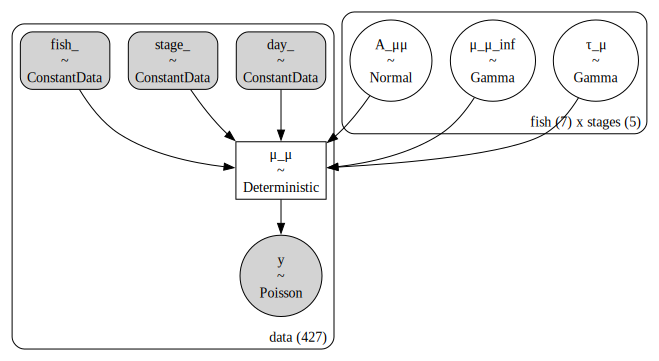

In [54]:
pm.model_to_graphviz(mg_suc)

# Priors
## Sample prior predictive

In [55]:
id_yds = pm.sample_prior_predictive(samples=200, model=mg_suc)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data

Sampling: [A_μμ, y, μ_μ_inf, τ_μ]


In [56]:
start_day = -25
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [57]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 20)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

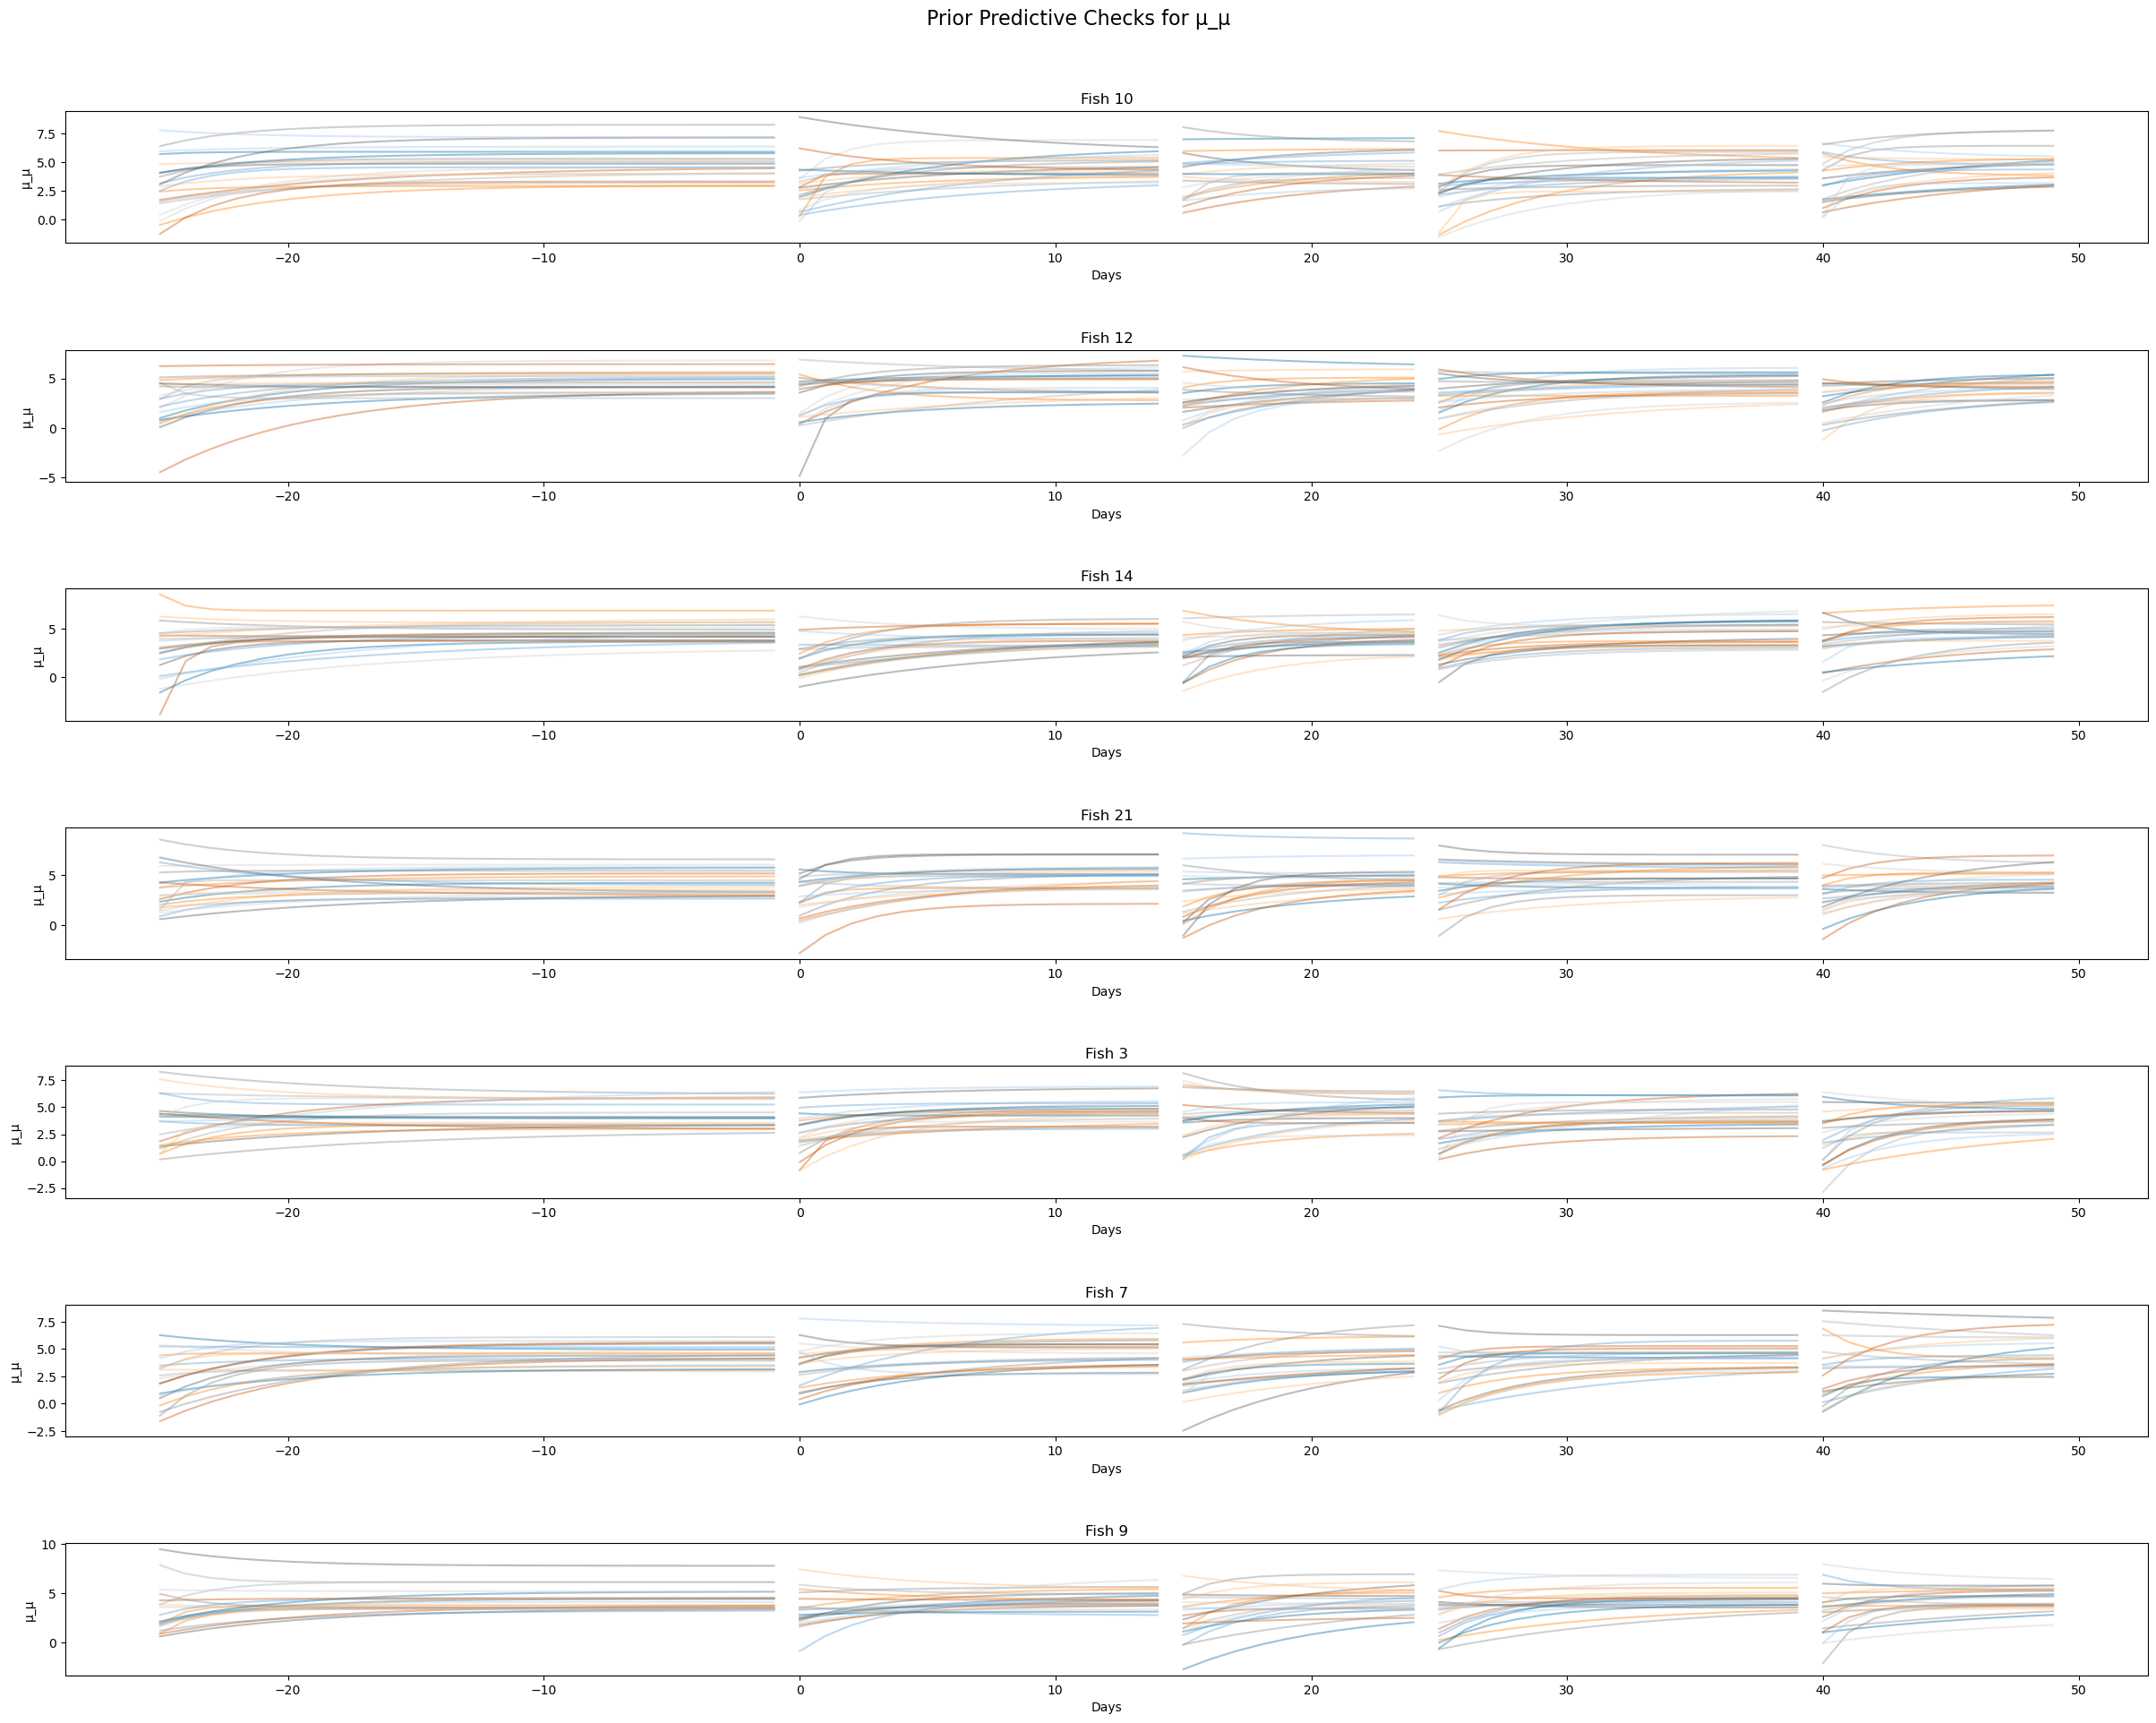

In [58]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

## NUTS sampler and diagnostics

In [59]:
with mg_suc:
    id_yds_numpyro = pm.sample(1000, tune=1000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ_μ, μ_μ_inf, A_μμ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.


In [60]:
with mg_suc:
    pm.sample_posterior_predictive(id_yds_numpyro, extend_inferencedata=True)

Sampling: [y]


In [61]:
az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[10, Rotation] -2.087  1.008  -3.971   -0.230      0.016    0.011   
A_μμ[12, Rotation] -0.949  1.065  -2.845    1.115      0.015    0.012   
A_μμ[14, Rotation] -1.216  1.083  -3.131    0.945      0.016    0.012   
A_μμ[21, Rotation] -1.919  1.171  -4.047    0.361      0.016    0.012   
A_μμ[3, Rotation]  -3.800  1.275  -5.991   -1.168      0.017    0.013   
A_μμ[7, Rotation]  -2.258  0.984  -4.073   -0.335      0.016    0.011   
A_μμ[9, Rotation]  -1.089  0.978  -2.799    0.856      0.016    0.012   

                    ess_bulk  ess_tail  r_hat  
A_μμ[10, Rotation]    4006.0    2811.0    1.0  
A_μμ[12, Rotation]    4859.0    2928.0    1.0  
A_μμ[14, Rotation]    4948.0    2748.0    1.0  
A_μμ[21, Rotation]    5244.0    3047.0    1.0  
A_μμ[3, Rotation]     5578.0    2531.0    1.0  
A_μμ[7, Rotation]     3913.0    2701.0    1.0  
A_μμ[9, Rotation]     3638.0    2856.0    1.0

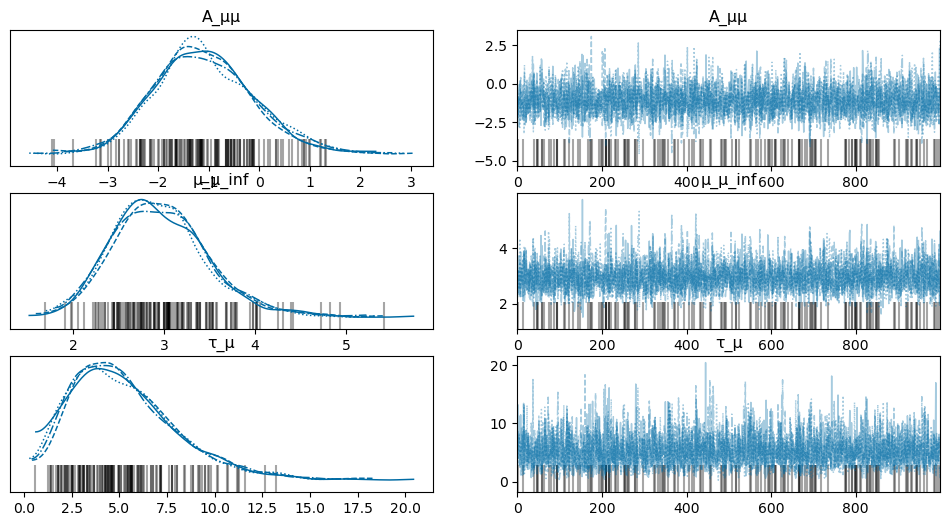

In [62]:
az.plot_trace(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf',  'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

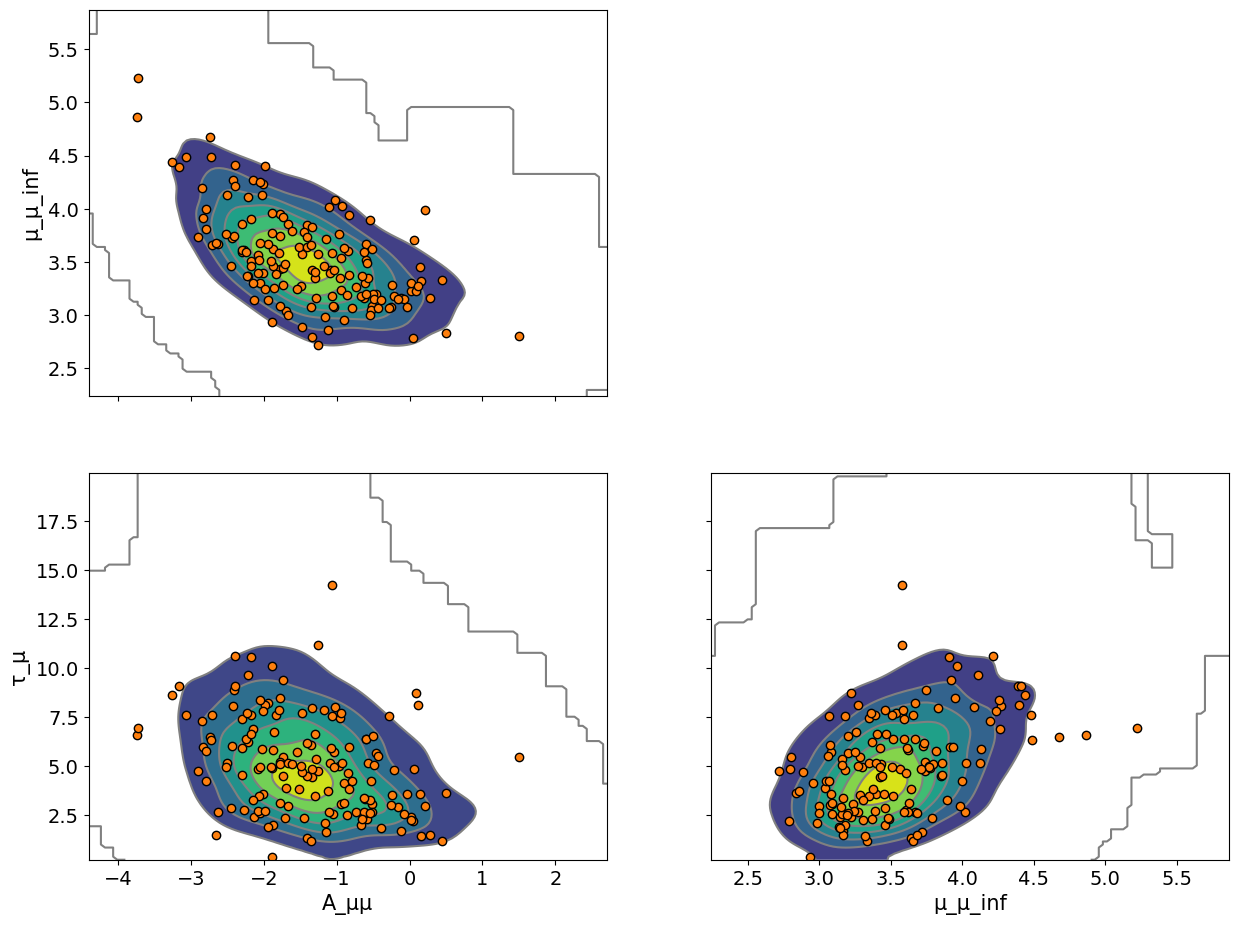

In [63]:
az.plot_pair(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'τ_μ'], 
             coords={'fish':10, 'stages': 'Baseline'}, 
             divergences=True,
             kind='kde');

In [64]:
posterior = id_yds_numpyro.posterior
ppc = id_yds_numpyro.posterior_predictive
cd = id_yds_numpyro.constant_data
obd = id_yds_numpyro.observed_data

In [65]:
μ_μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94) 

y_ppc_plot = az.summary(ppc, var_names=['y'], hdi_prob=0.94)

y_obd_plot = obd.y.to_dataframe(name="y")

μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94)

## Posterior preditive plots

In [66]:
def plot_hyperparameter_ppc_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 40)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(posterior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            posterior_fs = posterior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = posterior_fs[A_param]
            inf_fs = posterior_fs[inf_param]
            τ_fs = posterior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            ppc_param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index]  # Get the specific subplot
            for draw_idx in range(num_draws_to_plot):
                ax.plot(day_ranges[stage_id], ppc_param_vals.values.T[:, draw_idx, 1], alpha=0.4, label=f"Draw {draw_idx + 1}")

            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Posterior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

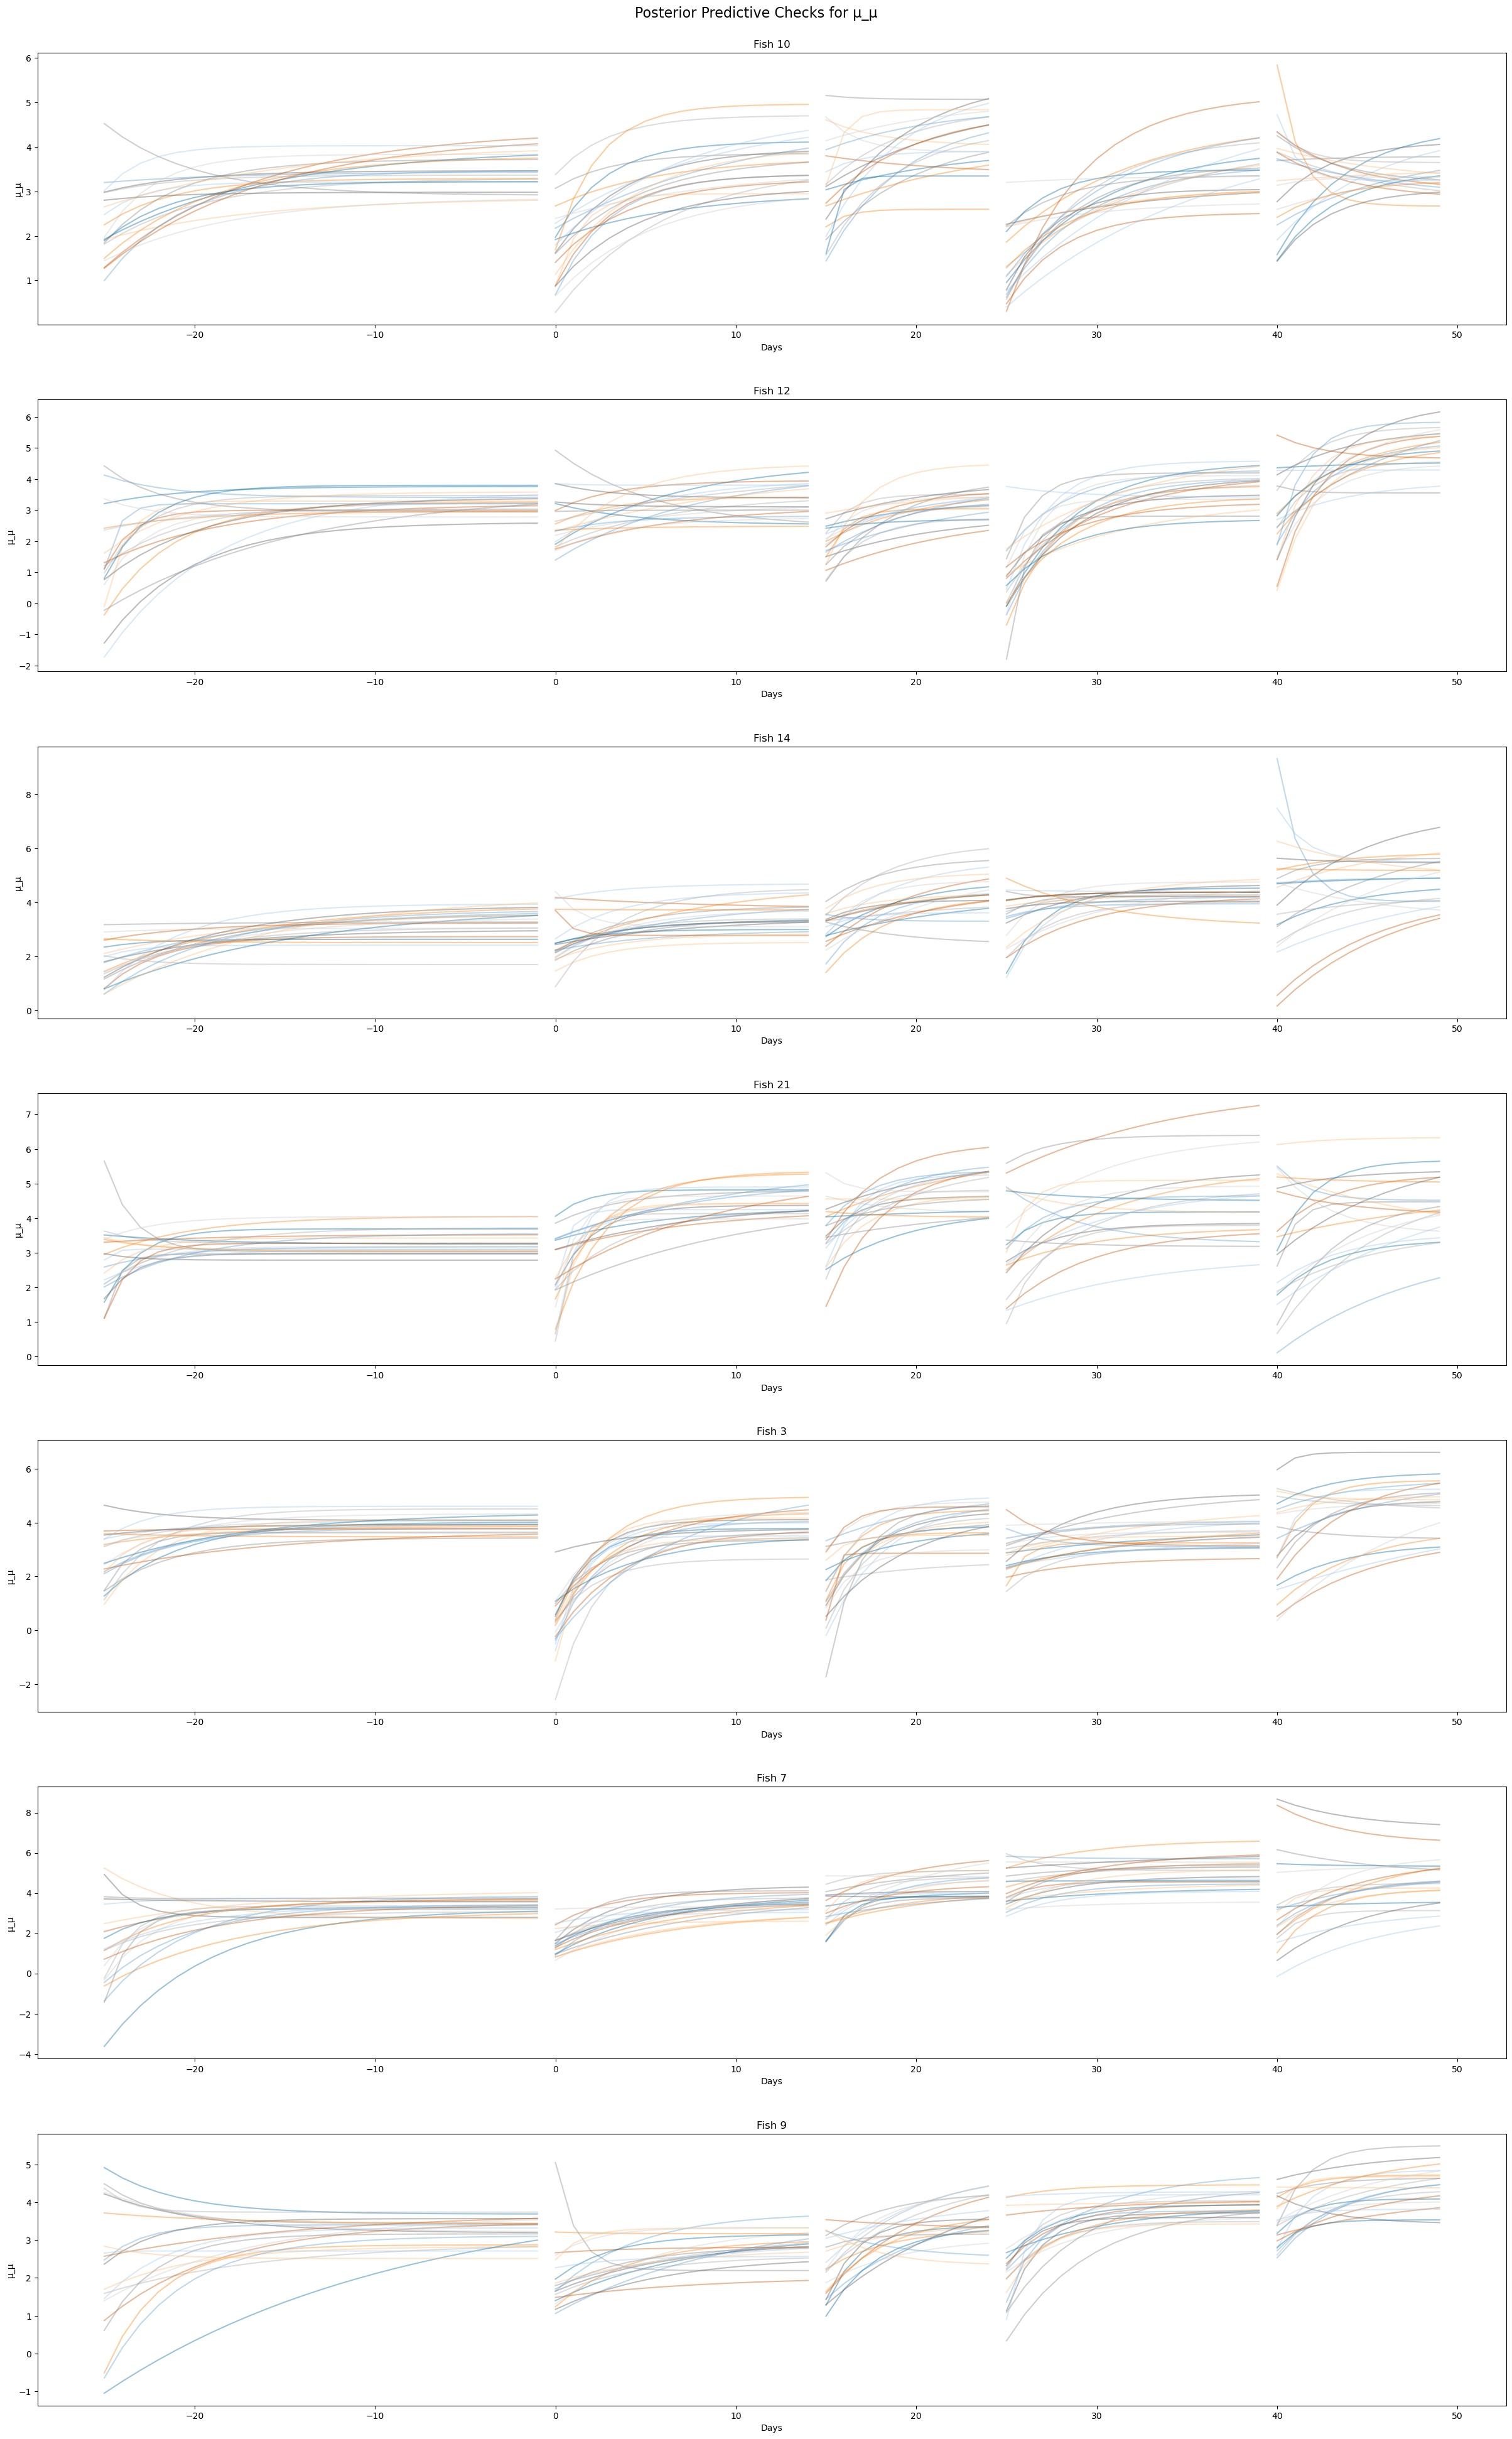

In [67]:
plot_hyperparameter_ppc_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

<Axes: title={'center': 'y'}>

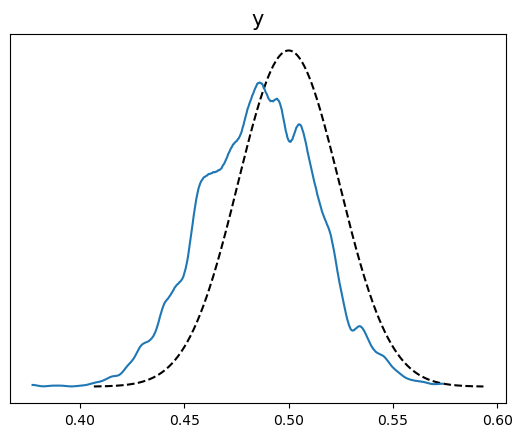

In [138]:
az.plot_bpv(id_yds_numpyro, kind="p_value")

<Axes: title={'center': 'y'}>

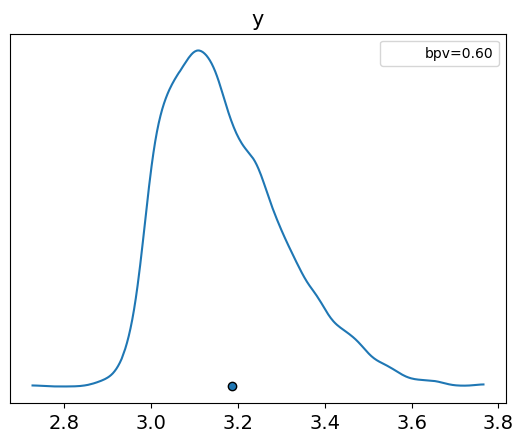

In [139]:
az.plot_bpv(id_yds_numpyro, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1))

In [68]:
fish_trial_phases = {
    '10': {
        'Baseline': (0, 23),
        'Rotation': (24, 38),
        'Washout': (39, 48),
        'ReRotation': (49, 62),
        'ReWashout' : (63,72)
    },
    '12': {
        'Baseline': (73, 96),
        'Rotation': (97, 111),
        'Washout': (112, 121),
        'ReRotation': (122,136 ),
        'ReWashout' : (137,146)
    },
    '14': {
        'Baseline': (147, 162),
        'Rotation': (163, 177),
        'Washout': (178, 187),
        'ReRotation': (188, 200)
    },
    '21': {
        'Baseline': (201,228),
        'Rotation': (229,243),
        'Washout': (244,253),
        'ReRotation':(254)
    },
    '3': {
        'Baseline': (255,278),
        'Rotation': (279, 293),
        'Washout': (294, 303),
        'ReRotation': (304, 311)
    },
    '7': {
        'Baseline': (312, 323),
        'Rotation': (324, 338),
        'Washout': (339, 348),
        'ReRotation': (349, 354)
    },
    '9': {
        'Baseline': (355, 376),
        'Rotation': (377, 391),
        'Washout': (392, 401),
        'ReRotation': (402, 416),
        'ReWashout' : (417,426)
    },


}

In [69]:
def get_trial_phase(index):
    for fish, phases in fish_trial_phases.items():
        for phase, bounds in phases.items():
            if isinstance(bounds, tuple):  # If bounds are a tuple (start, end)
                start, end = bounds
                if start <= index <= end:
                    return fish, phase, index - start + 1
            elif isinstance(bounds, int):  # If bounds are a single value
                if bounds == index:
                    return fish, phase, 1  # Assuming day starts at 1 if only end is given
    # Return default values (e.g., None) if no trial phase is found
    return None, None, None

# Create a new column 'index' to work with the index
y_obd_plot['index'] = y_obd_plot.index

# Apply function to create new columns 'fish', 'stage', 'day'
y_obd_plot['fish'], y_obd_plot['stage'], y_obd_plot['day'] = zip(*y_obd_plot['index'].map(get_trial_phase))

# Drop the 'index' column (optional)
y_obd_plot.drop(columns=['index'], inplace=True)



In [70]:


y_obd_plot['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
y_obd_plot['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

# Initialize plotday column with NaN
y_obd_plot['plotday'] = None
# Drop the 'index' column (optional)
# Iterate through each row to calculate plotday based on 'fish' and 'day'
current_fish = None
current_day = None
current_plotday = 0

for index, row in y_obd_plot.iterrows():
    if row['fish'] != current_fish:
        # New fish encountered, reset plotday to 1
        current_fish = row['fish']
        current_day = row['day']
        current_plotday = 1
    elif row['day'] != current_day:
        # Same fish but different day, increment plotday
        current_day = row['day']
        current_plotday += 1
    
    # Update plotday for the current row
    y_obd_plot.at[index, 'plotday'] = current_plotday

# Convert plotday column to numeric
y_obd_plot['plotday'] = pd.to_numeric(y_obd_plot['plotday'], errors='coerce')



y_obd_plot.to_csv('y_obdplot.csv', index=False)

In [71]:
# Rename columns in each DataFrame
μ_μ_plot_renamed = μ_μ_plot.rename(columns={'mean': 'μ_μ_y', 'hdi_3%': 'μ_μ_hdi_3%','hdi_97%': 'μ_μ_hdi_97%'})
μ_plot_renamed = μ_plot.rename(columns={'mean': 'μ_y', 'hdi_3%': 'μ_hdi_3%','hdi_97%': 'μ_hdi_97%'})
y_ppc_plot_renamed = y_ppc_plot.rename(columns={'mean': 'ppc_y', 'hdi_3%': 'ppc_hdi_3%','hdi_97%': 'ppc_hdi_97%'})

In [72]:
μ_μ_plot_renamed = μ_μ_plot_renamed.reset_index(drop=True) 
μ_plot_renamed = μ_plot_renamed.reset_index(drop=True) 
y_ppc_plot_renamed = y_ppc_plot_renamed.reset_index(drop=True) 

In [73]:
ppcplot_df = pd.concat([y_obd_plot, μ_μ_plot_renamed[['μ_μ_y','μ_μ_hdi_3%','μ_μ_hdi_97%']],μ_plot_renamed[['μ_y','μ_hdi_3%','μ_hdi_97%']], y_ppc_plot_renamed[['ppc_y','ppc_hdi_3%','ppc_hdi_97%']]], axis=1)

In [74]:
ppcplot_df['fish'] = pd.to_numeric(df['fish_id'], errors='coerce')
ppcplot_df['day'] = pd.to_numeric(df['day'], errors='coerce')
ppcplot_df['plotday'] = pd.to_numeric(df['plotday'], errors='coerce')
ppcplot_df['stage'] = df['stage']

In [75]:
ppcplot_df.to_csv('sucppcplot.csv',index=False)

## Figure 5

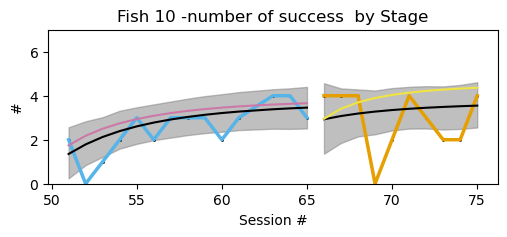

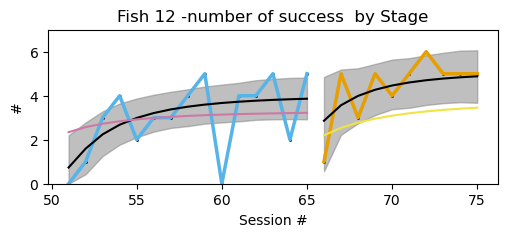

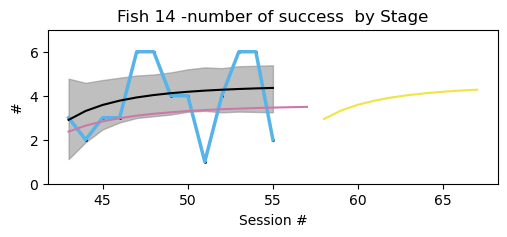

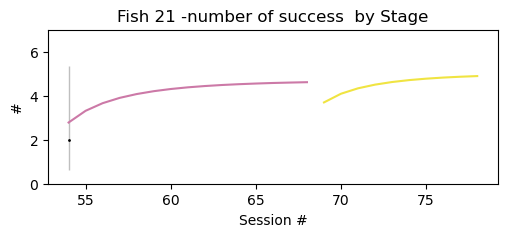

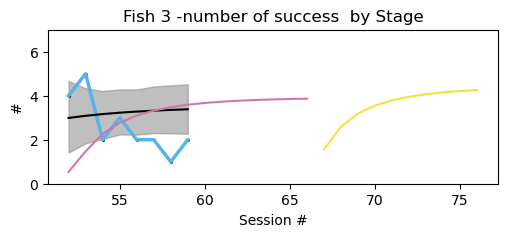

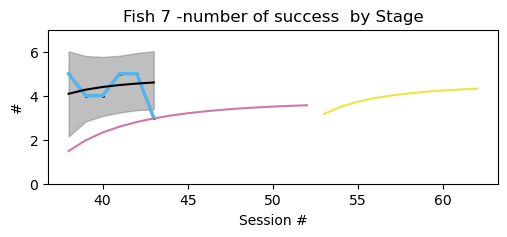

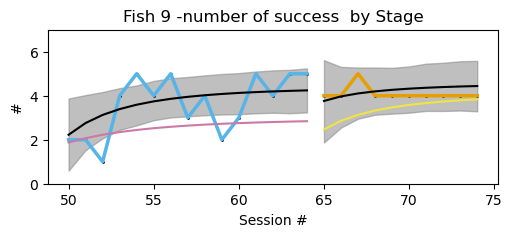

In [76]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df['fish'].unique():
    plt.figure(figsize=(5.8, 2))  # Set figure size
    plt.style.use('default')
    for i, stage in enumerate(stages_ReRReW):
# Filter data for the current fish and stage
        data_filter = ppcplot_df[(ppcplot_df['fish'] == fish) & (ppcplot_df['stage'] == stage)]

        plt.plot(data_filter['plotday'], data_filter['y'], label=f'number - {stage}', color=phase_colors[stage], linewidth=2.5)
        plt.plot(data_filter['plotday'], data_filter['μ_y'], label=f'number - {stage}', color='black')

        plt.fill_between(data_filter['plotday'], data_filter['μ_μ_hdi_3%'], data_filter['μ_μ_hdi_97%'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')

        plt.scatter(data_filter['plotday'],data_filter['y'],color= 'black',s =1)
    for i, stage in enumerate(stages_RW):
# Filter data for the current fish and stage
        data_filter3 = ppcplot_df[(ppcplot_df['fish'] == fish) & (ppcplot_df['stage'] == stage)]

        plt.plot(data_filter3['plotday']+25, data_filter3['μ_y'], label=f'number - {stage}', color=phase_colors[stage])



    plt.xlabel('Session #')  # Set x-axis label
    plt.ylabel('#')   # Set y-axis label
    plt.title(f'Fish {fish} -number of success  by Stage')  # Set plot title

    plt.ylim((0,7))
    plt.grid(False)  # Show grid
    Exampelplotfolder = os.path.join(plotfolder,'example/')
    plt.savefig(os.path.join(Exampelplotfolder, f'{fish}Figure5B.png'), bbox_inches='tight', dpi=600)

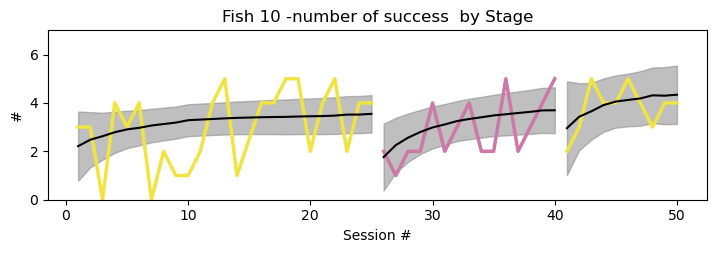

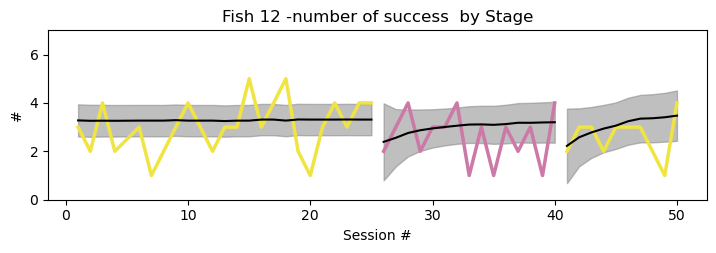

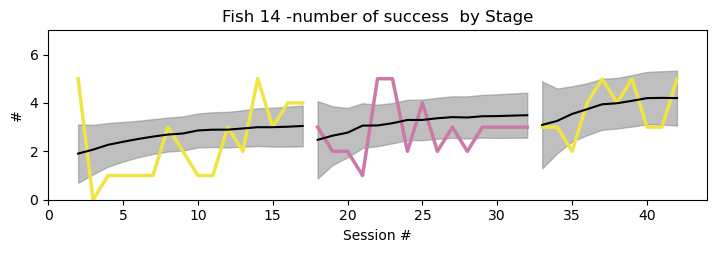

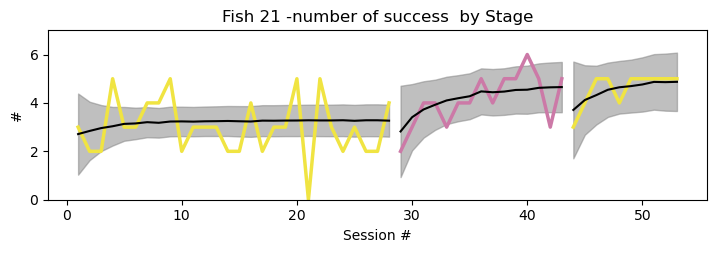

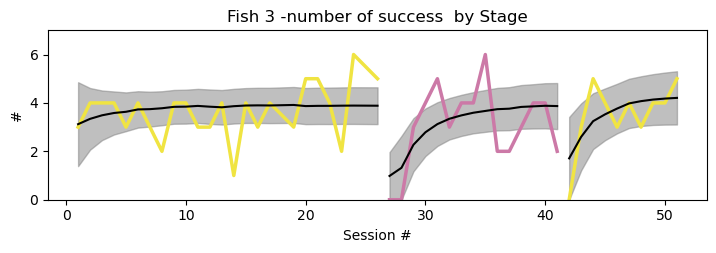

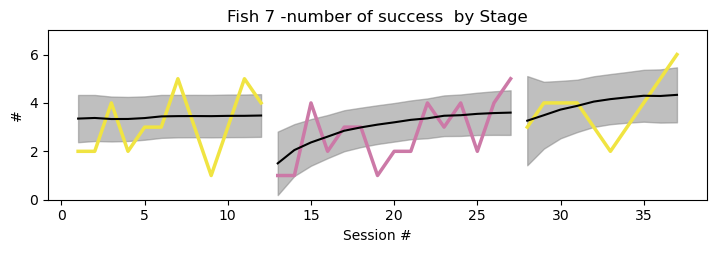

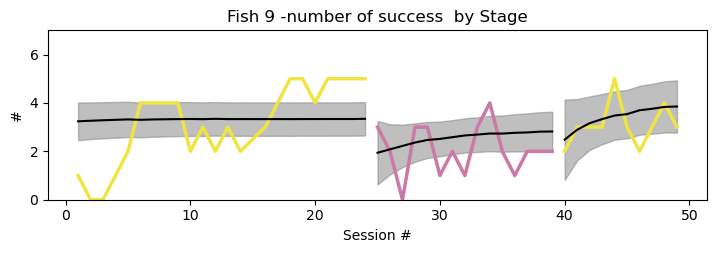

In [77]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df['fish'].unique():
    plt.figure(figsize=(8.5, 2.2))  # Set figure size
    plt.style.use('default')
    for i, stage in enumerate(stages_BWR):
# Filter data for the current fish and stage
        data_filter = ppcplot_df[(ppcplot_df['fish'] == fish) & (ppcplot_df['stage'] == stage)]

        plt.plot(data_filter['plotday'], data_filter['y'], label=f'number - {stage}', color=phase_colors[stage], linewidth=2.5)
       # plt.plot(data_filter['plotday'], data_filter['μ_y'], label=f'number - {stage}', color='black')

        plt.fill_between(data_filter['plotday'], data_filter['μ_μ_hdi_3%'], data_filter['μ_μ_hdi_97%'],color='grey', alpha=0.5, label=f'HDI μ_μ - {stage}')
        plt.plot(data_filter['plotday'], (data_filter['μ_μ_hdi_3%']+ data_filter['μ_μ_hdi_97%'])/2, label=f'number - {stage}', color='black')
      #  plt.scatter(data_filter['plotday'],data_filter['y'],color= 'black',s =1)
    
    plt.xlabel('Session #')  # Set x-axis label
    plt.ylabel('#')   # Set y-axis label
    plt.title(f'Fish {fish} -number of success  by Stage')  # Set plot title

    plt.ylim((0,7))
    plt.grid(False)  # Show grid
    Exampelplotfolder = os.path.join(plotfolder,'example/')
    plt.savefig(os.path.join(Exampelplotfolder, f'{fish}Figure3D.png'), bbox_inches='tight', dpi=600)

In [78]:
LR =(-1)*posterior.A_μμ / posterior.τ_μ
LR_R = LR.sel({'stages':'Rotation' })
LR_R_across = LR_R.mean(dim='fish')
LR_R_across = LR_R_across.values.flatten()
LR_ReR = LR.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
LR_ReR_across = LR_ReR.mean(dim='fish')
LR_ReR_across = LR_ReR_across.values.flatten()

In [79]:
LR_across = LR.mean(dim='fish')
ASuccessLR = az.summary(LR_across)
ASuccessLR.to_csv('ASuccessLR.csv')
ESuccessLR = az.summary(LR)
ESuccessLR.to_csv('ESuccessLR.csv')

In [80]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = LR_R.to_dataframe(name='LR').reset_index()
df_ReR = LR_ReR.to_dataframe(name='LR').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['LR', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['LR', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioLR = pd.concat([df_R[['LR', 'fish','session']],df_ReR[['LR','session','fish']]])
# Display the dataframe
print(df_vioLR)

             LR  fish     session
0      0.417013    10    Rotation
1      0.144492    12    Rotation
2      0.280457    14    Rotation
3      0.230021    21    Rotation
4      0.688173     3    Rotation
...         ...   ...         ...
27995  0.306376    14  ReRotation
27996  0.549187    21  ReRotation
27997  0.037407     3  ReRotation
27998 -0.092691     7  ReRotation
27999  0.600358     9  ReRotation

[56000 rows x 3 columns]


In [81]:
BP = posterior.μ_μ_inf
BP_R = BP.sel({'stages':'Rotation' })
BP_R_across = BP_R.mean(dim='fish')
BP_R_across = BP_R_across.values.flatten()
BP_ReR = BP.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
BP_ReR_across = BP_ReR.mean(dim='fish')
BP_ReR_across = BP_ReR_across.values.flatten()

In [82]:
BP_across = BP.mean(dim='fish')
ASuccessBP = az.summary(BP_across)
ASuccessBP.to_csv('ASuccessAP.csv')
ESuccessBP = az.summary(BP)
ESuccessBP.to_csv('ESuccessAP.csv')

In [83]:
# Assuming LR_R is your xarray.DataArray
# Flatten the DataArray and convert to a pandas DataFrame
df_R = BP_R.to_dataframe(name='BP').reset_index()
df_ReR = BP_ReR.to_dataframe(name='BP').reset_index()
# Assuming 'fish' is one of the dimensions and 'LR_Rdata' is the flattened data
# Select only 'LR_Rdata' and 'fish' columns
df_R = df_R[['BP', 'fish']]
df_R['session'] = 'Rotation'
df_ReR = df_ReR[['BP', 'fish']]
df_ReR['session'] = 'ReRotation'
df_vioBP = pd.concat([df_R[['BP', 'fish','session']],df_ReR[['BP','session','fish']]])


#  For the final version plots

### Learning rate Figure 7

In [84]:
LR_F = LR.mean(dim="fish")
LR_FR = LR_F.sel(stages=LR['stages'].isin(['Rotation', 'ReRotation']))
df_LR_FR = LR_FR.to_dataframe(name='LR_FR').reset_index()

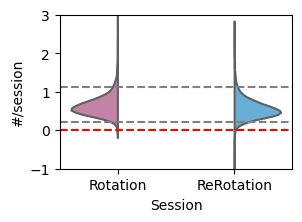

In [85]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
# Set the plotting style
plt.style.use('default')
# Plot the violin plots for each session
plt.figure(figsize=(3, 2))

sns.violinplot(data=df_LR_FR, x="stages", y="LR_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
# plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ASuccessLR.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessLR.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.title('Violin Plot of Learning Rates Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('#/session')
plt.ylim(-1, 3)
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure7A5.png'), bbox_inches='tight', dpi=600)

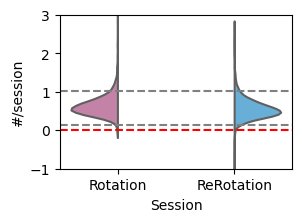

In [86]:

plt.figure(figsize=(3, 2))
sns.violinplot(data=df_LR_FR, x="stages", y="LR_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
# plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ASuccessLR.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessLR.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(-1, 3)
plt.ylabel('#/session')
#plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure7A6.png'), bbox_inches='tight', dpi=600)

### Asymptotic performance Figure 7

In [87]:
BP = posterior.μ_μ_inf
BP_R = BP.sel({'stages':'Rotation' })
BP_R_across = BP_R.mean(dim='fish')
BP_R_across = BP_R_across.values.flatten()
BP_ReR = BP.sel({'stages':'ReRotation' })
# Flatten the data array to a 1-dimensional numpy array
BP_ReR_across = BP_ReR.mean(dim='fish')
BP_ReR_across = BP_ReR_across.values.flatten()

In [88]:
BP_across = BP.mean(dim='fish')
ASuccessBP = az.summary(BP_across)
ASuccessBP.to_csv('ASuccessAP.csv')
ESuccessBP = az.summary(BP)
ESuccessBP.to_csv('ESuccessAP.csv')

In [89]:
BP_F = BP.mean(dim="fish")
BP_FR = BP_F.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_FR = BP_FR.to_dataframe(name='BP_FR').reset_index()

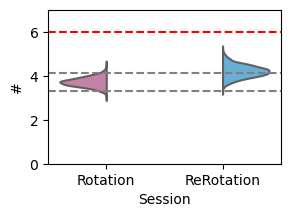

In [90]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_FR , x="stages", y="BP_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
# plt.axhspan(rope_min+6, rope_max+6, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ASuccessBP.loc['μ_μ_inf[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessBP.loc['μ_μ_inf[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ASuccessBP.loc['μ_μ_inf[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ASuccessBP.loc['μ_μ_inf[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(0, 7)
plt.ylabel('#')
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=6, color='red', linestyle='--')
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure7A3.png'), bbox_inches='tight', dpi=600)

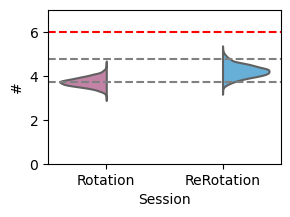

In [91]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_FR , x="stages", y="BP_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
#plt.axhspan(rope_min+6, rope_max+6, color='grey', alpha=0.3, label='ROPE')

# plt.axhline(y=ASuccessBP.loc['μ_μ_inf[Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ASuccessBP.loc['μ_μ_inf[Rotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessBP.loc['μ_μ_inf[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessBP.loc['μ_μ_inf[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')

plt.ylim(0, 7)
plt.ylabel('#')
#plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=6, color='red', linestyle='--')
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure7A4.png'), bbox_inches='tight', dpi=600)

In [92]:
BP_SR = BP.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_BP_SR = BP_SR.to_dataframe(name='BP_SR').reset_index()

In [93]:
df_BP_SR

chain  draw  fish      stages     BP_SR
0          0     0    10    Rotation  3.552924
1          0     0    10  ReRotation  3.802314
2          0     0    12    Rotation  3.183160
3          0     0    12  ReRotation  2.417316
4          0     0    14    Rotation  2.863866
...      ...   ...   ...         ...       ...
55995      3   999     3  ReRotation  2.868692
55996      3   999     7    Rotation  3.618779
55997      3   999     7  ReRotation  2.994654
55998      3   999     9    Rotation  2.592807
55999      3   999     9  ReRotation  4.890269

[56000 rows x 5 columns]

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


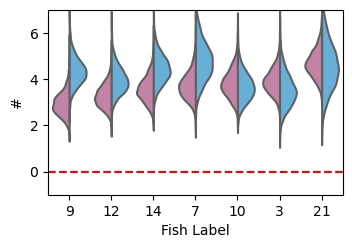

In [94]:
# Calculate the mean learning rate for each fish in the "Rotation" session
BP_SR_medians = df_BP_SR[df_BP_SR ['stages'] == 'Rotation'].groupby('fish')['BP_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_BP_SR_median = BP_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_BP_SR ['fish'] = pd.Categorical(df_BP_SR ['fish'], categories=sorted_BP_SR_median, ordered=True)
df_BP_SR   =df_BP_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_BP_SR ['stages'] = pd.Categorical(df_BP_SR ['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_BP_SR  = df_BP_SR .sort_values(by=['stages', 'fish'])

plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_BP_SR , x="fish", y="BP_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_BP_SR_median, scale='width')

plt.ylim(-1,7)
plt.xlabel('Fish Label' )
plt.ylabel('#')
plt.axhline(y=0, color='red', linestyle='--')


# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()

### Figure 7 initial error

In [95]:
IE = posterior.A_μμ + posterior.μ_μ_inf
IE_SR = IE.sel(stages=IE['stages'].isin(['Rotation', 'ReRotation']))
df_IE_SR = IE_SR.to_dataframe(name='IE_SR').reset_index()

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


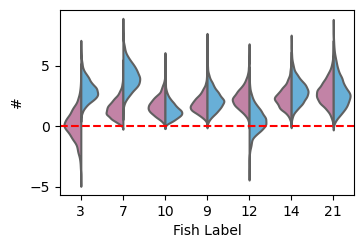

In [96]:
# Calculate the mean learning rate for each fish in the "Rotation" session
IE_SR_medians = df_IE_SR[df_IE_SR ['stages'] == 'Rotation'].groupby('fish')['IE_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_IE_SR_median = IE_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_IE_SR ['fish'] = pd.Categorical(df_IE_SR ['fish'], categories=sorted_IE_SR_median, ordered=True)
df_IE_SR   =df_IE_SR.sort_values('fish')
#  Create a categorical type for the 'stages' column
df_IE_SR ['stages'] = pd.Categorical(df_IE_SR ['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_IE_SR  = df_IE_SR .sort_values(by=['stages', 'fish'])

plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_IE_SR , x="fish", y="IE_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_IE_SR_median, scale='width')

# plt.ylim(-3.8, 2.4)
plt.xlabel('Fish Label' )
plt.ylabel('#')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[3, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[21, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[9, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[7, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[10, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[12, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[12, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ELengthLR.loc['x[14, Rotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
plt.legend().set_visible(False)
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()

In [97]:
IE_F = IE.mean(dim="fish")
IE_FR = IE_F.sel(stages=BP['stages'].isin(['Rotation', 'ReRotation']))
df_IE_FR = IE_FR.to_dataframe(name='IE_FR').reset_index()

In [98]:
ASuccessIE = az.summary(IE_F)
ASuccessIE.to_csv('ASuccessIE.csv')
ESuccessIE = az.summary(BP)
ESuccessIE.to_csv('ESuccessIE.csv')

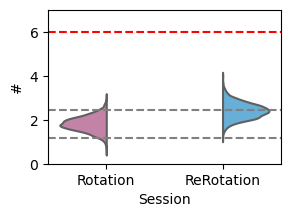

In [99]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_IE_FR , x="stages", y="IE_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
# plt.axhspan(rope_min+6, rope_max+6, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ASuccessIE.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessIE.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')
plt.ylim(0, 7)
plt.ylabel('#')
plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=6, color='red', linestyle='--')
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure7A1.png'), bbox_inches='tight', dpi=600)

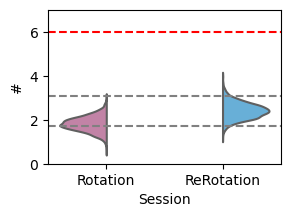

In [100]:

# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}
plt.figure(figsize=(3, 2))
sns.violinplot(data=df_IE_FR , x="stages", y="IE_FR", hue="stages", split=True, palette=color['session'], inner=None)
# Add ROPE
# plt.axhspan(rope_min+6, rope_max+6, color='grey', alpha=0.3, label='ROPE')

# plt.axhline(y=ASuccessIE.loc['x[Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ASuccessIE.loc['x[Rotation]','hdi_97%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessIE.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessIE.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.xlabel('Session')
plt.ylim(0, 7)
plt.ylabel('#')
# plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Best performance Across Sessions')
plt.axhline(y=6, color='red', linestyle='--')
plt.legend().set_visible(False)

plt.savefig(os.path.join(plotfolder, f'Figure7A2.png'), bbox_inches='tight', dpi=600)

## Figure 8 negative correlation

In [101]:
rotation_data = LR.sel(stages='Rotation')
rerotation_data = LR.sel(stages='ReRotation')

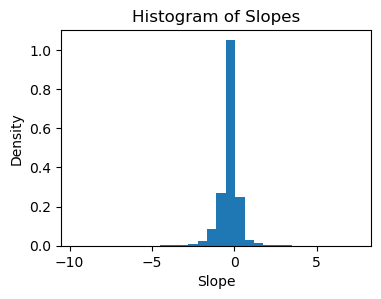

C:\Users\86153\AppData\Local\Temp\ipykernel_55188\3776081288.py:40: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_regression_lines = az.hdi(regression_lines, hdi_prob=0.94)


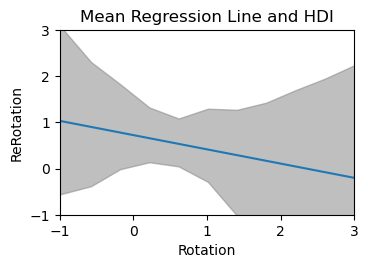

In [102]:
# Initialize lists to store the regression parameters
slopes = []
intercepts = []

# Perform linear regression for each (chain, draw)
for chain in range(rotation_data.shape[0]):
    for draw in range(rotation_data.shape[1]):
        x = rotation_data[chain, draw, :].values
        y = rerotation_data[chain, draw, :].values
        slope, intercept = np.polyfit(x, y, 1)
        slopes.append(slope)
        intercepts.append(intercept)

# Convert slopes and intercepts to arrays
slopes = np.array(slopes)
intercepts = np.array(intercepts)

# Plot histogram of slopes
plt.figure(figsize=(4, 2.8))
plt.hist(slopes, bins=30, density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of Slopes')
plt.show()

# Plot mean regression line and HDI
x_vals = np.linspace(rotation_data.values.min(), rotation_data.values.max(), 100)

# Compute regression lines
regression_lines = []
for i in range(len(slopes)):
    regression_lines.append(intercepts[i] + slopes[i] * x_vals)

regression_lines = np.array(regression_lines)

# Mean regression line
mean_regression_line = regression_lines.mean(axis=0)

# HDI of regression lines
hdi_regression_lines = az.hdi(regression_lines, hdi_prob=0.94)

plt.figure(figsize=(3.8, 2.4))
plt.plot(x_vals, mean_regression_line, label='Mean Regression Line')
plt.fill_between(x_vals, hdi_regression_lines[:, 0], hdi_regression_lines[:, 1], color='gray', alpha=0.5, label='94% HDI')
plt.ylim(-1,3)
plt.xlim(-1,3)


plt.xlabel('Rotation')
plt.ylabel('ReRotation')
plt.title('Mean Regression Line and HDI')
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure8B.png'), bbox_inches='tight', dpi=600)

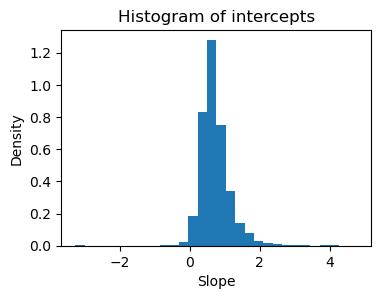

In [103]:
# Plot histogram of intercepts
plt.figure(figsize=(4, 2.8))
plt.hist(intercepts, bins=30, density=True)
plt.xlabel('Slope')
plt.ylabel('Density')
plt.title('Histogram of intercepts')
plt.show()

In [104]:
az.summary(slopes)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
x -0.308  0.68  -1.656    0.588      0.012    0.008    3324.0    3210.0    NaN

## Figure8 learning rate for each fish

In [105]:
LR_SR = LR.sel(stages=LR['stages'].isin(['Rotation', 'ReRotation']))
df_LR_SR = LR_SR.to_dataframe(name='LR_SR').reset_index()

color = {'session':{"Rotation": '#CC79A7', "ReRotation": '#56B4E9'}}

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


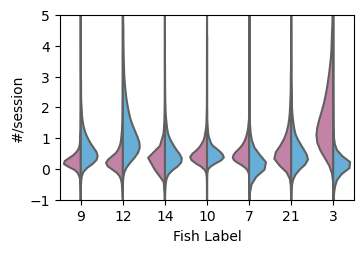

In [106]:
# Calculate the mean learning rate for each fish in the "Rotation" session
LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_LR_SR_median = LR_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_LR_SR ['fish'] = pd.Categorical(df_LR_SR ['fish'], categories=sorted_LR_SR_median, ordered=True)
df_LR_SR  = df_LR_SR.sort_values('fish')
df_LR_SR['stages'] = pd.Categorical(df_LR_SR['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_LR_SR = df_LR_SR.sort_values(by=['stages', 'fish'])
plt.figure(figsize=(3.8, 2.4))
sns.violinplot(data=df_LR_SR, x="fish", y="LR_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_LR_SR_median, scale='width')

plt.ylim(-1, 5)
plt.xlabel('Fish Label')
plt.ylabel('#/session')
# plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[3, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[3, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[21, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[21, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[9, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[9, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[7, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[7, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[10, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[10, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[12, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[12, Rotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[14, Rotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[14, Rotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
# plt.legend().set_visible(False)
plt.legend().set_visible(False)
plt.savefig(os.path.join(plotfolder, f'Figure8A.png'), bbox_inches='tight', dpi=600)

C:\Users\86153\AppData\Local\Temp\ipykernel_55188\2130076062.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()
c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


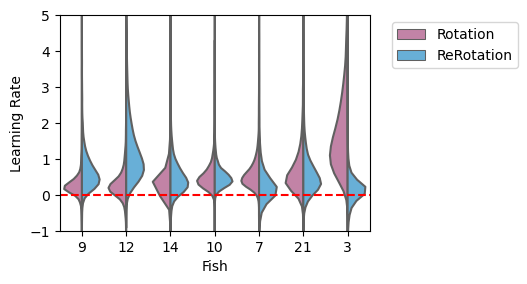

In [107]:
# Calculate the mean learning rate for each fish in the "Rotation" session
LR_SR_medians = df_LR_SR [df_LR_SR ['stages'] == 'Rotation'].groupby('fish')['LR_SR'].median()

# Sort fish by mean learning rate in "Rotation" session in descending order
sorted_LR_SR_median = LR_SR_medians.sort_values(ascending=True).index

# Reorder the DataFrame according to the sorted fish
df_LR_SR ['fish'] = pd.Categorical(df_LR_SR ['fish'], categories=sorted_LR_SR_median, ordered=True)
df_LR_SR  = df_LR_SR.sort_values('fish')
df_LR_SR['stages'] = pd.Categorical(df_LR_SR['stages'], categories=['Rotation', 'ReRotation'], ordered=True)
# Sort the DataFrame by 'stages' and then by 'fish'
df_LR_SR = df_LR_SR.sort_values(by=['stages', 'fish'])
plt.figure(figsize=(4, 2.8))
sns.violinplot(data=df_LR_SR, x="fish", y="LR_SR", hue="stages", split=True, palette=color['session'], inner=None, order=sorted_LR_SR_median, scale='width')

plt.ylim(-1, 5)
plt.xlabel('Fish')
plt.ylabel('Learning Rate')
plt.axhline(y=0, color='red', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[3, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[3, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[21, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[21, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[9, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[9, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[7, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[7, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[10, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[10, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[12, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[12, ReRotation]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[14, ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ESuccessLR.loc['x[14, ReRotation]','hdi_97%'], color='grey', linestyle='--')

# Add legend
# plt.legend().set_visible(False)
plt.legend( bbox_to_anchor=(1.5, 1))
#plt.title('Violin Plot of Learning Rates with HDI Intervals')
# plt.grid(False)
plt.show()


In [108]:
id_yds_numpyro.constant_data.day_.isel(data = [24, 97, 163, 229, 279, 324, 377])

<xarray.DataArray 'day_' (data: 7)> Size: 28B
array([0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * data     (data) int32 28B 24 97 163 229 279 324 377

In [109]:
id_yds_numpyro.constant_data.fish_.isel(data = [24, 97, 163, 229, 279, 324, 377])

<xarray.DataArray 'fish_' (data: 7)> Size: 28B
array([0, 1, 2, 3, 4, 5, 6])
Coordinates:
  * data     (data) int32 28B 24 97 163 229 279 324 377

In [110]:
R_μ_μ = None


In [111]:
# Define start indices and number of stages
R_start_indices = [24, 97, 163, 229, 279, 324, 377]
num_sessions = 15

# Generate indices for each stage
R_sessions = [[start + i for start in R_start_indices] for i in range(num_sessions)]

# Extract data and concatenate along a new dimension
R_μ_μ = xr.concat([posterior.μ_μ.isel(data=idx) for idx in R_sessions], dim='sessions')

# Assign stage labels, if desired
R_μ_μ = R_μ_μ.assign_coords(sessions=[f'R{i+1}' for i in range(num_sessions)])

In [112]:
ASuccessIE

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[Baseline]    1.968  0.536   0.995    2.969      0.007    0.005    5696.0   
x[Rotation]    1.818  0.336   1.183    2.440      0.005    0.004    3862.0   
x[Washout]     2.700  0.380   2.023    3.432      0.006    0.004    4740.0   
x[ReRotation]  2.417  0.368   1.707    3.071      0.006    0.004    3869.0   
x[ReWashout]   3.096  0.676   1.806    4.321      0.008    0.006    6889.0   

               ess_tail  r_hat  
x[Baseline]      3385.0    1.0  
x[Rotation]      3202.0    1.0  
x[Washout]       2954.0    1.0  
x[ReRotation]    3108.0    1.0  
x[ReWashout]     3112.0    1.0

In [113]:
hdi_fish = R_μ_μ .mean(dim = 'data') 
az.summary(hdi_fish)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_μ[R1]   1.877  0.306   1.333    2.468      0.005    0.004    3623.0   
μ_μ[R2]   2.318  0.244   1.868    2.774      0.004    0.003    3560.0   
μ_μ[R3]   2.649  0.207   2.281    3.057      0.003    0.002    3674.0   
μ_μ[R4]   2.883  0.187   2.531    3.241      0.003    0.002    3786.0   
μ_μ[R5]   3.054  0.176   2.740    3.400      0.003    0.002    3937.0   
μ_μ[R6]   3.183  0.171   2.866    3.508      0.003    0.002    4118.0   
μ_μ[R7]   3.282  0.168   2.981    3.612      0.003    0.002    4249.0   
μ_μ[R8]   3.359  0.169   3.042    3.668      0.003    0.002    4353.0   
μ_μ[R9]   3.420  0.170   3.111    3.744      0.003    0.002    4462.0   
μ_μ[R10]  3.469  0.173   3.144    3.788      0.003    0.002    4554.0   
μ_μ[R11]  3.509  0.176   3.189    3.837      0.003    0.002    4645.0   
μ_μ[R12]  3.542  0.179   3.203    3.862      0.003    0.002    4723.0   
μ_μ[R13]  3.568  0.182   3.238    3.909      0.003    0.002    4793.0   
μ_μ[R14]  3.591  0.184   3.238    3.921      0.003    0.002    4860.0   
μ_μ[R15]  3.609  0.187   3.262    3.952      0.003    0.002    4924.0   

          ess_tail  r_hat  
μ_μ[R1]     3094.0    1.0  
μ_μ[R2]     3329.0    1.0  
μ_μ[R3]     3086.0    1.0  
μ_μ[R4]     3237.0    1.0  
μ_μ[R5]     3168.0    1.0  
μ_μ[R6]     3128.0    1.0  
μ_μ[R7]     3432.0    1.0  
μ_μ[R8]     3615.0    1.0  
μ_μ[R9]     3640.0    1.0  
μ_μ[R10]    3619.0    1.0  
μ_μ[R11]    3565.0    1.0  
μ_μ[R12]    3709.0    1.0  
μ_μ[R13]    3657.0    1.0  
μ_μ[R14]    3692.0    1.0  
μ_μ[R15]    3682.0    1.0

In [114]:
posterior_μ_μ = posterior["μ_μ"]
day_ = id_yds_numpyro.constant_data["day_"]
stage_ = id_yds_numpyro.constant_data["stage_"]
fish_ = id_yds_numpyro.constant_data["fish_"]


In [115]:
# Assign all coordinates
posterior_μ_μ_with_coords = posterior_μ_μ.assign_coords(day_=day_, stage_=stage_, fish_=fish_)

In [116]:
# Extract coordinates
day_ = posterior_μ_μ_with_coords.coords['day_'].values
stage_ = posterior_μ_μ_with_coords.coords['stage_'].values

# Initialize index lists
B_indices = [[] for _ in range(25)]  # For day_ = 0 to 24, stage_ = 0
R_indices = [[] for _ in range(15)]  # For day_ = 0 to 14, stage_ = 1
W_indices = [[] for _ in range(10)]  # For day_ = 0 to 9, stage_ = 2
ReR_indices = [[] for _ in range(15)]  # For day_ = 0 to 14, stage_ = 3
ReW_indices = [[] for _ in range(10)]  # For day_ = 0 to 9, stage_ = 4
# Iterate over all indices
for i in range(len(day_)):
    d = day_[i]
    s = stage_[i]
    
    # Check conditions and append indices to the corresponding lists
    if s == 0 and 0 <= d < 25:
        B_indices[d].append(i)
    elif s == 1 and 0 <= d < 15:
        R_indices[d].append(i)
    elif s == 2 and 0 <= d < 10:
        W_indices[d].append(i)
    elif s == 3 and 0 <= d < 15:
        ReR_indices[d].append(i)
    elif s == 4 and 0 <= d < 10:
        ReW_indices[d].append(i)



In [117]:
# Initialize empty lists to store data
mean_list = []
hdi_list = []

# Prepare containers for means and HDI summaries
for stage, indices_list, days_range in zip(
    ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout'], 
    [B_indices, R_indices, W_indices, ReR_indices, ReW_indices],
    [25, 15, 10, 15, 10]
):
    for d in range(days_range):
        indices = indices_list[d]
        if indices:
            # Extract data for the current day
            μ_μ_d = posterior.μ_μ.isel(data=indices)
            μ_μ_d_mean = μ_μ_d.mean(dim='data')
            
            # Compute HDI
            hdi_summary = az.summary(μ_μ_d_mean)
            
            # Append means and HDI summaries
            mean_list.append({
                'Stage': stage,
                'Day': d,
                'Mean': μ_μ_d_mean.values,
            })
            hdi_list.append({
                'Stage': stage,
                'Day': d,
                'HDI_Lower': hdi_summary['hdi_3%'].values,
                'HDI_Upper': hdi_summary['hdi_97%'].values,
                'Mean': hdi_summary['mean'].values,
            })

# Create DataFrames
mean_df = pd.DataFrame(mean_list)
hdi_df = pd.DataFrame(hdi_list)

In [118]:
# Function to safely convert strings with list-like values to numeric
def safe_convert(value):
    try:
        # Handle lists in strings
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            value = value.strip('[]')
            value = float(value.split(',')[0].strip())
        else:
            value = float(value)
        return value
    except ValueError:
        return float('nan')

# Apply conversion to each column
hdi_df['HDI_Lower'] = hdi_df['HDI_Lower'].apply(safe_convert)
hdi_df['HDI_Upper'] = hdi_df['HDI_Upper'].apply(safe_convert)
hdi_df['Mean'] = hdi_df['Mean'].apply(safe_convert)
# Assuming hdi_df is your DataFrame
num_rows = len(hdi_df)

# Create the 'PlotDay' column with values from -25 to 49
hdi_df['PlotDay'] = range(-25, -25 + num_rows)

C:\Users\86153\AppData\Local\Temp\ipykernel_55188\394746875.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(value)


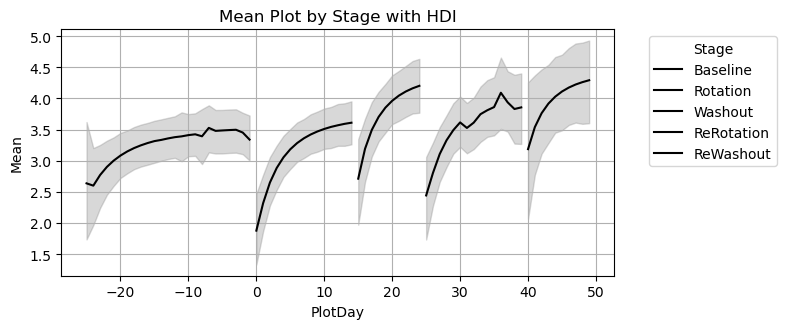

In [119]:
# Get unique stages
stages = hdi_df['Stage'].unique()

# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
plt.style.use('default')
for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
plt.title('Mean Plot by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

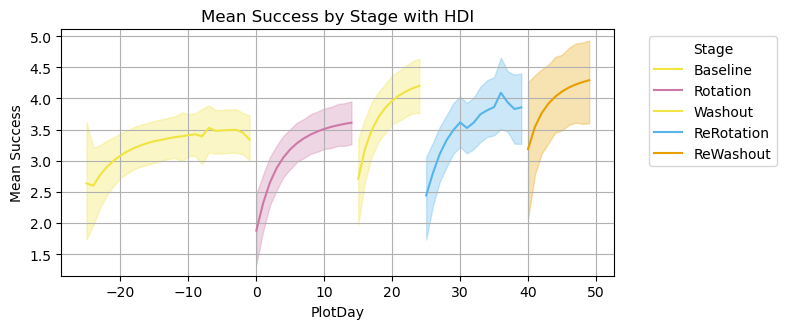

In [120]:
# Get unique stages
stages = hdi_df['Stage'].unique()
# Create a plot for each stage
plt.figure(figsize=(8, 3.4))
for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color=phase_colors.get(stage, 'black'),  # Use the same color as the line
                     alpha=0.3, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean Success')
plt.title('Mean Success by Stage with HDI')
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [121]:
hdi_df.to_csv('SuccessAfish.csv')

In [122]:
median_df = []
# Calculate median for each combination of stage, fish, and plotday

# Define stages in the desired order
stages_All = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'ReWashout']

# Sample DataFrame (replace with your actual DataFrame)
median_df = y_obd_plot.groupby(['fish', 'stage', 'day', 'plotday'])['y'].median().reset_index()

# Convert 'stage' column to a categorical type with the specified order
median_df['stage'] = pd.Categorical(median_df['stage'], categories=stages_All, ordered=True)

# Sort the DataFrame based on 'fish', 'stage', 'day', and 'plotday'
median_df = median_df.sort_values(by=['fish', 'stage', 'day', 'plotday']).reset_index(drop=True)


In [123]:
# Initialize the 'PlotDay' column with NaN values
median_df['PlotDay'] = pd.NA

def assign_plotday(df):
    if df.empty:
        return df
    
    # Find the index of the first 'Rotation' stage
    rotation_indices = df[df['stage'] == 'Rotation'].index
    
    if not rotation_indices.empty:
        # Get the index of the first occurrence of 'Rotation' for the current fish
        rotation_index = rotation_indices[0]
        
        # Set PlotDay to 0 for the first 'Rotation' day
        df.at[rotation_index, 'PlotDay'] = 0
        
        # Assign 'PlotDay' for days before the 'Rotation' stage
        for i in range(rotation_index - 1, -1, -1):
            df.at[i, 'PlotDay'] = df.at[i + 1, 'PlotDay'] - 1
        
        # Assign 'PlotDay' for days after the 'Rotation' stage
        for i in range(rotation_index + 1, len(df)):
            df.at[i, 'PlotDay'] = df.at[i - 1, 'PlotDay'] + 1
                
    return df

# Apply the function to each fish's data
median_df = median_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)
# Remove rows where 'fish' is NaN
median_df = median_df.dropna(subset=['fish']).reset_index(drop=True)
# Display the updated DataFrame for verification

median_df.to_csv('median.csv')

C:\Users\86153\AppData\Local\Temp\ipykernel_55188\1840302809.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = median_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)


## Figure 2 and 4

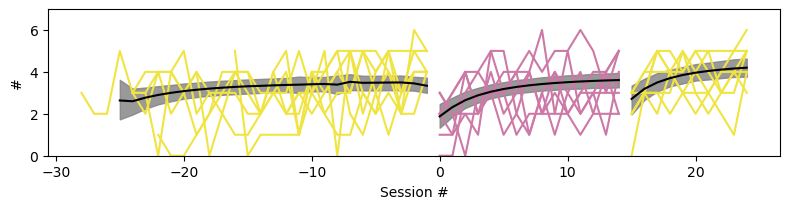

In [124]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('#')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,7)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels


plt.savefig(os.path.join(plotfolder, f'Figure4A.png'), bbox_inches='tight', dpi=600)
     

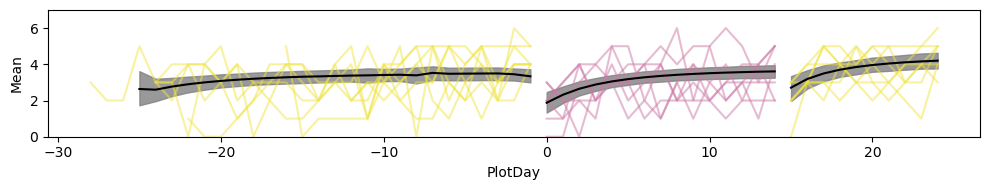

In [125]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(10, 2))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=0.5 )  # Default to black if stage not in color map

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,7)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [126]:
PPC_plot_df = []
PPC_plot_df = ppcplot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)
PPC_plot_df = PPC_plot_df.dropna(subset=['fish']).reset_index(drop=True)
PPC_plot_df = PPC_plot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)

C:\Users\86153\AppData\Local\Temp\ipykernel_55188\1539168761.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  PPC_plot_df = ppcplot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)
C:\Users\86153\AppData\Local\Temp\ipykernel_55188\1539168761.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  PPC_plot_df = PPC_plot_df.groupby('fish').apply(assign_plotday).reset_index(drop=True)


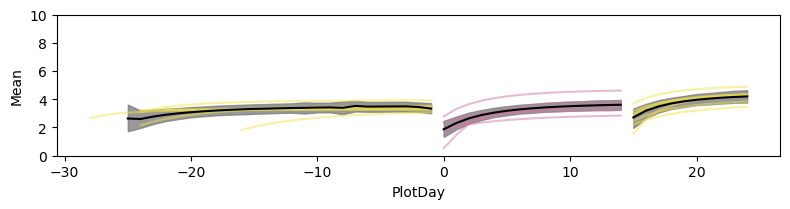

In [127]:
# Get unique stages
stages = stages_BWR

# Create a plot for each stage
plt.figure(figsize=(8, 2.2))
plt.style.use('default')
# for fish in median_df['fish'].unique():
#     for stage in stages:
#         # Filter data for the current fish and stage
#         medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
#         # Plot the mean line for the current fish and stage
#         plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
#                  label=stage, color=phase_colors.get(stage, 'black'),alpha=0.5 )  # Default to black if stage not in color map
for fish in PPC_plot_df['fish'].unique():
    for i, stage in enumerate(stages_BWR):
        data_filter = PPC_plot_df [(PPC_plot_df['fish'] == fish) & (PPC_plot_df['stage'] == stage)]        
        plt.plot(data_filter['PlotDay'], data_filter['μ_μ_y'], label=f'μ_μ_y - {stage}', color=phase_colors.get(stage, 'black'),alpha=0.5)

for stage in stages:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)

# Add labels and title
plt.xlabel('PlotDay')
plt.ylabel('Mean')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,10)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure4A2.png'), bbox_inches='tight', dpi=600)

## Figure 6

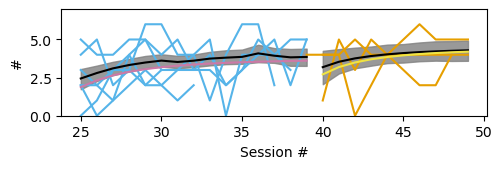

In [128]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
for fish in median_df['fish'].unique():
    for stage in stages_ReRReW:
        # Filter data for the current fish and stage
        medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
        # Plot the mean line for the current fish and stage
        plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
                 label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map

for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('#')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,7)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure6A2.png'), bbox_inches='tight', dpi=600)

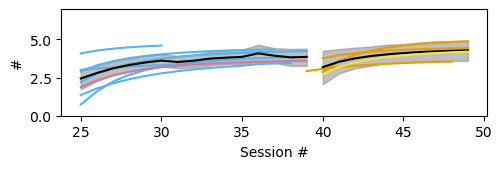

In [129]:


# Create a plot for each stage
plt.figure(figsize=(5, 1.8))
plt.style.use('default')
# for fish in median_df['fish'].unique():
#     for stage in stages_ReRReW:
#         # Filter data for the current fish and stage
#         medianEFish = median_df[(median_df['fish'] == fish) & (median_df['stage'] == stage)]
        
#         # Plot the mean line for the current fish and stage
#         plt.plot(medianEFish['PlotDay'], medianEFish['y'], 
#                  label=stage, color=phase_colors.get(stage, 'black'),alpha=1 )  # Default to black if stage not in color map
for fish in PPC_plot_df['fish'].unique():
    for i, stage in enumerate(stages_ReRReW):
        data_filter = PPC_plot_df [(PPC_plot_df['fish'] == fish) & (PPC_plot_df['stage'] == stage)]        
        plt.plot(data_filter['PlotDay'], data_filter['μ_μ_y'], label=f'μ_μ_y - {stage}', color=phase_colors.get(stage, 'black'),alpha=1)


for stage in stages_ReRReW:
    # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
    
    # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay'], stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map

    # Plot the HDI shading for the current stage
    plt.fill_between(stage_data['PlotDay'], 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.5, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
    
for stage in stages_RW:
     # Filter data for the current stage
    stage_data = hdi_df[hdi_df['Stage'] == stage]
        # Plot the mean line for the current stage
    plt.plot(stage_data['PlotDay']+25 ,stage_data['Mean'], 
             label=stage, color=phase_colors.get(stage, 'black'))  # Default to black if stage not in color map

# Add labels and title
plt.xlabel('Session #')
plt.ylabel('#')
# plt.title('Mean Plot by Stage with HDI')
# plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.ylim(0,7)  # Set fixed data range for y-axis
plt.grid(False)  # Show grid
# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig(os.path.join(plotfolder, f'Figure6A.png'), bbox_inches='tight', dpi=600)

## Figure for baseline

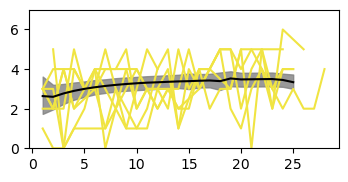

In [130]:
# Create a plot for each stage
plt.figure(figsize=(4, 1.8))
plt.style.use('default')

for fish in ppcplot_df['fish'].unique():
        data_filter = ppcplot_df[(ppcplot_df['fish'] == fish) & (ppcplot_df['stage'] =='Baseline')]

        plt.plot(data_filter['plotday'], data_filter['y'], label=f'number - {stage}', color=phase_colors[stage])


    # Filter data for the current stage
stage_data = stage_data = hdi_df[hdi_df['Stage'] == 'Baseline']
    
    # Plot the mean line for the current stage
plt.plot(stage_data['PlotDay']+26, stage_data['Mean'], 
             label=stage, color='black')  # Default to black if stage not in color map
    
    # Plot the HDI shading for the current stage
plt.fill_between(stage_data['PlotDay']+26, 
                     stage_data['HDI_Lower'], 
                     stage_data['HDI_Upper'],
                     color='grey',  # Use the same color as the line
                     alpha=0.8, 
                     label=f'HDI μ_μ - {stage}' if stage not in plt.gca().get_legend_handles_labels()[1] else None)
plt.ylim(0,7) 

plt.savefig(os.path.join(plotfolder, f'Figure3C.png'), bbox_inches='tight', dpi=600)

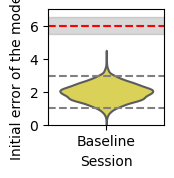

In [131]:
IE_FR_B = IE_F.sel(stages=BP['stages'].isin(['Baseline']))
df_IE_B = IE_FR_B.to_dataframe(name='IE_FR_B').reset_index()
  # Yellow
# Define the bounds of the ROPE
rope_min = 0.5
rope_max = -0.5
color = {'session':{'Baseline': '#F0E442'}}
plt.figure(figsize=(1.5, 1.5))
sns.violinplot(data=df_IE_B , x="stages", y="IE_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+6, rope_max+6, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ASuccessIE.loc['x[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessIE.loc['x[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')

plt.ylim(0, 7)
plt.xlabel('Session')

plt.ylabel('Initial error of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=6, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure2B.png'), bbox_inches='tight', dpi=600)

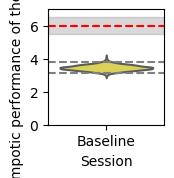

In [132]:
BP_FR_B = BP_F.sel(stages=BP['stages'].isin(['Baseline']))
df_FR_B = BP_FR_B.to_dataframe(name='BP_FR_B').reset_index()
  # Yellow

color = {'session':{'Baseline': '#F0E442'}}
plt.figure(figsize=(1.5, 1.5))
sns.violinplot(data=df_FR_B , x="stages", y="BP_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min+6, rope_max+6, color='grey', alpha=0.3, label='ROPE')

plt.axhline(y=ASuccessBP.loc['μ_μ_inf[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessBP.loc['μ_μ_inf[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_3%'], color='grey', linestyle='--')
# plt.axhline(y=ALengthBP.loc['x[ReRotation]','hdi_97%'], color='grey', linestyle='--')
plt.ylim(0, 7)
# plt.ylim(-8, 20)
plt.xlabel('Session')

plt.ylabel('Asympotic performance of the modelfit')
plt.legend().set_visible(False)
#plt.title('Best performance Across Sessions')
plt.axhline(y=6, color='red', linestyle='--')
plt.savefig(os.path.join(plotfolder, f'Figure2B2.png'), bbox_inches='tight', dpi=600)

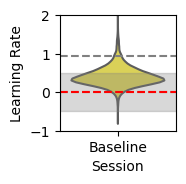

In [133]:
LR_FR_B = LR_F.sel(stages=LR['stages'].isin(['Baseline']))
df_LR_FR_B = LR_FR_B.to_dataframe(name='LR_FR_B').reset_index()
color = {'session':{'Baseline': '#F0E442'}}
# Set the plotting style
plt.style.use('default')
# Plot the violin plots for each session
plt.figure(figsize=(1.5, 1.5))

sns.violinplot(data=df_LR_FR_B, x="stages", y="LR_FR_B", palette=color['session'], inner=None)
# Add ROPE
plt.axhspan(rope_min, rope_max, color='grey', alpha=0.3, label='ROPE')
plt.axhline(y=ASuccessLR.loc['x[Baseline]','hdi_3%'], color='grey', linestyle='--')
plt.axhline(y=ASuccessLR.loc['x[Baseline]','hdi_97%'], color='grey', linestyle='--')
# plt.title('Violin Plot of Learning Rates Across Sessions')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Session')
plt.ylabel('Learning Rate')
plt.legend().set_visible(False)
plt.ylim(-1, 2)

plt.savefig(os.path.join(plotfolder, f'Figure2C.png'), bbox_inches='tight', dpi=600)

# Debug

## The difference of intial performance

Text(0.5, 1.0, 'Initial Performace difference across Fish')

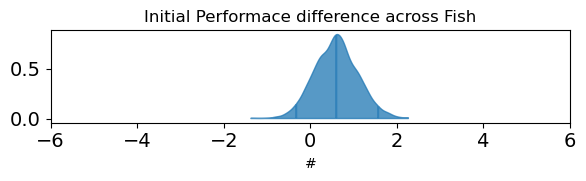

In [134]:
# Step 1: Select the data for 'ReRotation' and 'Rotation'
IE_S = IE.sel(stages='ReRotation')
IE_R = IE.sel(stages='Rotation')
dIE_SR = IE_S - IE_R
dIE_SR_F = dIE_SR.mean(dim="fish")
plt.figure(figsize=(6.7, 1.2))
az.plot_dist(dIE_SR_F, quantiles=[.03, .5, .97])

plt.xlabel('#')
plt.xlim(-6,6)
plt.title('Initial Performace difference across Fish')

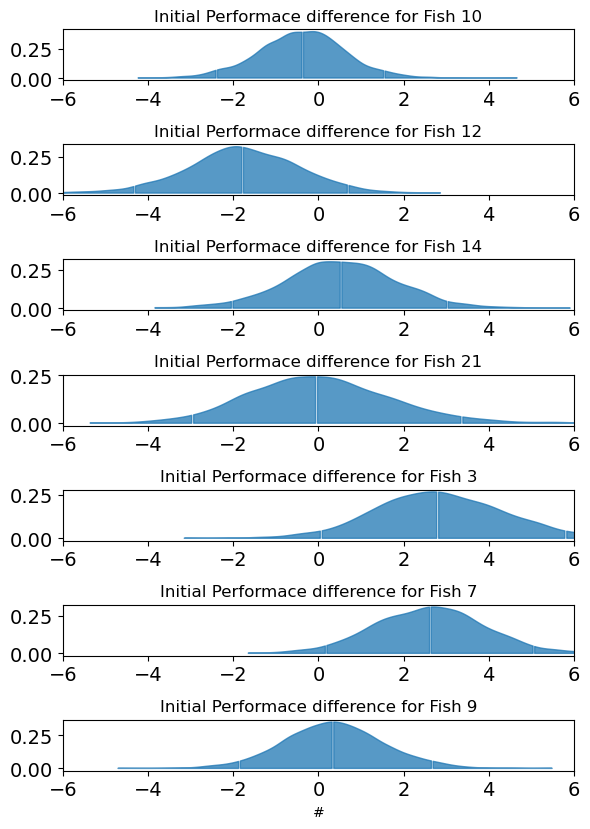

In [135]:
# Assuming dSR is your DataArray
fish_dim = dIE_SR.coords['fish']

# Create a figure with subplots for each fish
fig, axes = plt.subplots(len(fish_dim), 1, figsize=(6, len(fish_dim) * 1.2))

# If there's only one fish, axes might not be an array, so we need to handle that case
if len(fish_dim) == 1:
    axes = [axes]

# Iterate over each fish and plot its distribution
for i, fish in enumerate(fish_dim):
    az.plot_dist(dIE_SR.sel(fish=fish), quantiles=[.03, .5, .97],  ax=axes[i])
    axes[i].set_title(f'Initial Performace difference for Fish {fish.item()}')
    axes[i].set_xlim(-6, 6)
plt.xlabel('#')
plt.tight_layout()
plt.show()

## difference of asymptotic performane 

Text(0.5, 1.0, 'Asymptotic Performace difference across Fish')

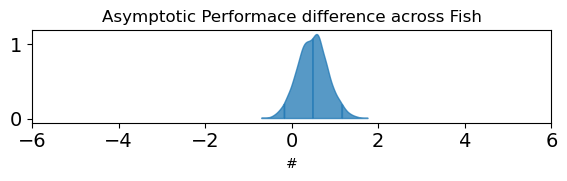

In [136]:
# Step 1: Select the data for 'ReRotation' and 'Rotation'
AP_S = BP.sel(stages='ReRotation')
AP_R = BP.sel(stages='Rotation')
dAP_SR = AP_S - AP_R
dAP_SR_F = dAP_SR.mean(dim="fish")
plt.figure(figsize=(6.7, 1.2))
az.plot_dist(dAP_SR_F, quantiles=[.03, .5, .97])
plt.xlabel('#')
plt.xlim(-6,6)
plt.title('Asymptotic Performace difference across Fish')

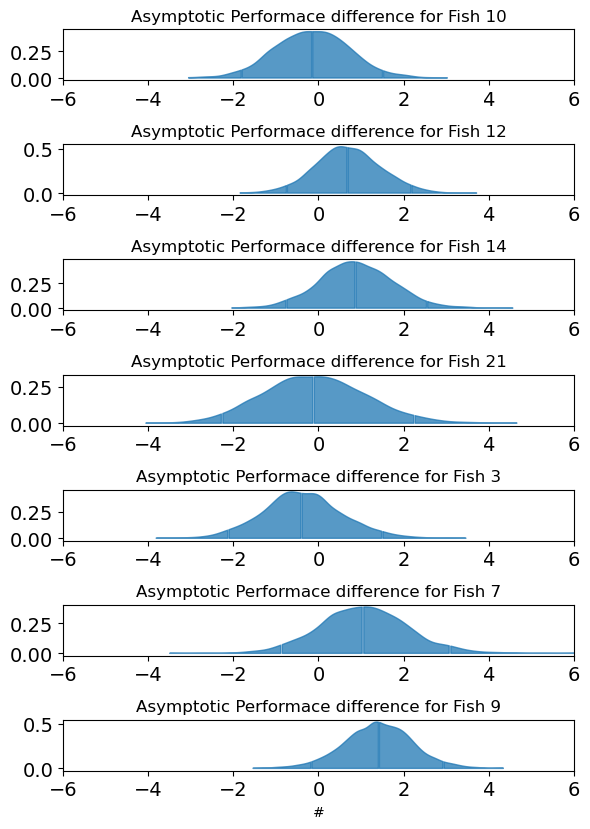

In [137]:
# Assuming dSR is your DataArray
fish_dim = dAP_SR.coords['fish']

# Create a figure with subplots for each fish
fig, axes = plt.subplots(len(fish_dim), 1, figsize=(6, len(fish_dim) * 1.2))

# If there's only one fish, axes might not be an array, so we need to handle that case
if len(fish_dim) == 1:
    axes = [axes]

# Iterate over each fish and plot its distribution
for i, fish in enumerate(fish_dim):
    az.plot_dist(dAP_SR.sel(fish=fish), quantiles=[.03, .5, .97],  ax=axes[i])

    axes[i].set_title(f'Asymptotic Performace difference for Fish {fish.item()}')
    axes[i].set_xlim(-6, 6)
plt.xlabel('#')
plt.tight_layout()
plt.show()